In [1]:
!pip install opencv-contrib-python==3.4.0.12 
# otherwise you'd get an error message saying this when you try to use SIFT
# This algorithm is patented and is excluded in this configuration; 
# Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in 
# function 'cv::xfeatures2d::SIFT::create'

     |████████████████████████████████| 30.5MB 151kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
import numpy as np
import pandas as pd

from scipy import ndimage, signal
from scipy.ndimage import gaussian_filter
from copy import deepcopy
import matplotlib.pyplot as plt

import random
import math
import os

!pip install opencv-python
import cv2

import plotly.graph_objects as go

from google.colab.patches import cv2_imshow

In [3]:
def get_images(path0, path1):
  img0 = cv2.imread(path0, cv2.IMREAD_GRAYSCALE)
  img1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)

  return img0, img1

In [4]:
def perform_SIFT(img1, img2, threshold=0.5):
  # temp naming everything SIFT
  # sift = cv2.xfeatures2d.SIFT_create()
  # kp1_SIFT, desc1_SIFT = sift.detectAndCompute(img1, None)
  # kp2_SIFT, desc2_SIFT = sift.detectAndCompute(img2, None)

  surf = cv2.xfeatures2d.SURF_create()
  kp1_SIFT, desc1_SIFT = surf.detectAndCompute(img1, None)
  kp2_SIFT, desc2_SIFT = surf.detectAndCompute(img2, None)

  # orb = cv2.ORB_create(nfeatures=1000)
  # kp1_SIFT, desc1_SIFT = orb.detectAndCompute(img1, None)
  # kp2_SIFT, desc2_SIFT = orb.detectAndCompute(img2, None)

  img1_SIFT = cv2.drawKeypoints(img1, kp1_SIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))
  img2_SIFT = cv2.drawKeypoints(img2, kp1_SIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(255,255,0))

  #plt.figure()
  #fig, axs = plt.subplots(2,figsize=(10,10))
  #axs[0].imshow(img1_SIFT)
  #plt.subplot(1, 2, 2)
  #axs[1].imshow(img2_SIFT)
  #plt.show()

  kp1 = kp1_SIFT
  kp2 = kp2_SIFT
  desc1 = desc1_SIFT
  desc2 = desc2_SIFT

  bf = cv2.BFMatcher()
  matches = bf.knnMatch(desc1, desc2, k=2) # k=2 means find the top two matchs for each query descriptor

  # Apply ratio test (as per David Lowe's SIFT paper: compare the best match with the 2nd best match_
  good_matches = []
  good_matches_without_list = []
  for m,n in matches:
      if m.distance < threshold*n.distance: # only accept matchs that are considerably better than the 2nd best match
          good_matches.append([m])
          good_matches_without_list.append(m) # this is to simplify finding a homography later

  #plt.figure()
  img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,
                          None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, 
                          matchColor=(0,255,0))
  #plt.figure(figsize = (10,10))
  #plt.imshow(img3), plt.show()

  src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2)
  dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches_without_list ]).reshape(-1,1,2)

  return src_pts, dst_pts

In [5]:
def extract_calibration_vals(file, image_numbers):
    image1, image2 = image_numbers

    calib_vals = {}
    temple_par = pd.read_csv("dino_par.txt", delimiter=' ', dtype=str, skiprows=[0], index_col=0, header=None)
    temple_par.columns = ['k11', 'k12', 'k13', 'k21', 'k22', 'k23', 
                          'k31', 'k32', 'k33', 'r11', 'r12', 'r13', 
                          'r21', 'r22', 'r23', 'r31', 'r32', 'r33', 
                          't1', 't2', 't3']
    temple_par.index.name = 'image name'
    K0 = temple_par.iloc[image1,0:9].values.reshape(3,3).astype(float)
    R0 = temple_par.iloc[image1,9:18].values.reshape(3,3).astype(float)
    t0 = temple_par.iloc[image1,18:].values.reshape(3,1).astype(float)
    K1 = temple_par.iloc[image2,0:9].values.reshape(3,3).astype(float)
    R1 = temple_par.iloc[image2,9:18].values.reshape(3,3).astype(float)
    t1 = temple_par.iloc[image2,18:].values.reshape(3,1).astype(float)
    calib_vals['cam0'] = K0
    calib_vals['cam1'] = K1
    calib_vals['R0'] = R0
    calib_vals['R1'] = R1
    calib_vals['t0'] = t0
    calib_vals['t1'] = t1
    calib_vals['baseline'] = np.linalg.norm(t1 - t0)
    return calib_vals

In [12]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [6]:
def compute_epipolar_lines(F, img1, img2, pts1, pts2):
  # Find epilines corresponding to points in right image (second image) and
  # drawing its lines on left image
  lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
  lines1 = lines1.reshape(-1,3)
  img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
  # Find epilines corresponding to points in left image (first image) and
  # drawing its lines on right image
  lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
  lines2 = lines2.reshape(-1,3)
  img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

  fig, axs = plt.subplots(2,1, figsize=(20, 10))
  axs[0].imshow(img5)
  axs[1].imshow(img3)

  #axs[0].imshow(img4)
  #axs[1].imshow(img6)
  #plt.subplot(122),plt.imshow(img3)
  plt.show()

In [21]:
def open_cv_homography(img0, img1, F, img0_pts, img1_pts):
  thresh = 0
  height, width = img0.shape
  _, H0, H1 = cv2.stereoRectifyUncalibrated(
      np.float32(img0_pts), np.float32(img1_pts), F, imgSize=(width, height), threshold=thresh,
  )

  img0_rectified = cv2.warpPerspective(img0, H0, (width, height))
  img1_rectified = cv2.warpPerspective(img1, H1, (width, height))
  cv2_imshow(img0_rectified)
  cv2_imshow(img1_rectified)

  return H0, H1, img0_rectified, img1_rectified

In [20]:
def get_image_properties(path0, path1, calibration_filepath, image_numbers):
  img0, img1 = get_images(path0, path1)
  rgb0 = cv2.imread(path0)

  # Acquire camera information
  calib_vals = extract_calibration_vals(calibration_filepath, image_numbers)
  K0 = calib_vals['cam0']
  K1 = calib_vals['cam1']
  f = K0[0,0]
  
  R0 = calib_vals['R0']
  R1 = calib_vals['R1']

  t0 = calib_vals['t0']
  t1 = calib_vals['t1']

  R1_camera_coord_0 = R1 @ R0.transpose()
  t1_camera_coord_0 = t0 - R1_camera_coord_0.transpose() @ t1

  # Extract matching points from the imgs
  img0_pts, img1_pts = perform_SIFT(img0, img1, threshold=0.75)

  # fundamental matrix
  KRt = K0 @ R1_camera_coord_0 @ t1_camera_coord_0
  cross_product_matrix_KRt = np.asarray([[0, -KRt[2][0], KRt[1][0]], [KRt[2][0], 0, -KRt[0][0]], [-KRt[1][0], KRt[0][0], 0]])

  #F = np.linalg.inv(K1).transpose() @ R1_camera_coord_0 @ K0.transpose() @ cross_product_matrix_KRt
  F = cross_product_matrix_KRt @ (K1 @ R1) @ np.linalg.inv(K0 @ R0)

  return (f, K0, K1, R0, R1, t0, t1, F)

In [19]:
def run(image_index_0, image_index_1):
  base_image_path = "dino{:04d}.png"

  image_path_0 = base_image_path.format(image_index_0)
  image_path_1 = base_image_path.format(image_index_1)


  f, K0, K1, R0, R1, t0, t1, F = get_image_properties(image_path_0, image_path_1, "dino_par.txt", image_numbers=(image_index_0-1, image_index_1-1))
  #print(F/F[-1,-1])
  img0, img1 = get_images(image_path_0, image_path_1)
  scp, dsp = perform_SIFT(img0, img1)
  compute_epipolar_lines(F, img0, img1, scp.squeeze(), dsp.squeeze())

  H0, H1, img0_rectified, img1_rectified = open_cv_homography(img0, img1, F, scp.squeeze(), dsp.squeeze())

  print("Sanity Check")

  Fbar = np.asarray([[0,0,0],[0,0,-1],[0,1,0]])
  F_recap = H1.transpose() @ Fbar @ H0
  print("Ensure the following matrices are equal [H1.T @ Fbar @ H0 = F]")
  print(F_recap / F_recap[-1,-1])
  print(F/F[-1,-1])

  return (f, K0, K1, R0, R1, t0, t1, F, H0, H1, img0_rectified, img1_rectified)

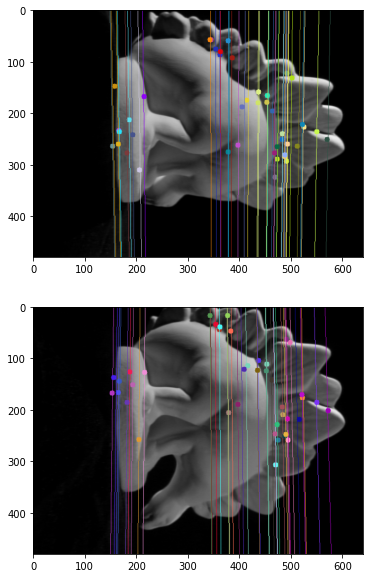

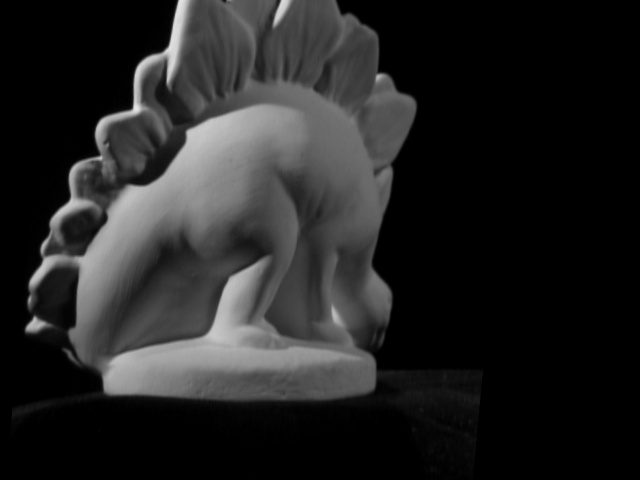

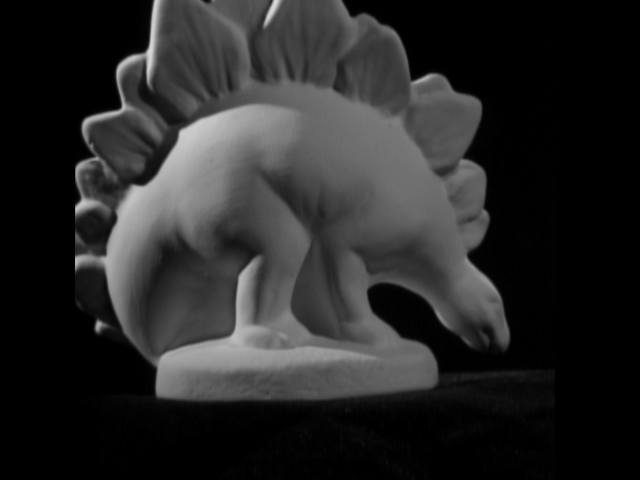

Sanity Check
Ensure the following matrices are equal [H1.T @ Fbar @ H0 = F]
[[ 4.28898347e-08  6.74582613e-06 -8.52259555e-02]
 [ 7.04664167e-06 -4.27587228e-08 -2.04282382e-03]
 [ 8.21581989e-02 -2.46327088e-03  1.00000000e+00]]
[[ 4.28898347e-08  6.74582613e-06 -8.52259555e-02]
 [ 7.04664167e-06 -4.27587228e-08 -2.04282382e-03]
 [ 8.21581989e-02 -2.46327088e-03  1.00000000e+00]]


In [23]:
output = run(image_index_0 = 10, image_index_1 = 6)

calculated_parameters = output[:10]
img0_rectified = output[10]
img1_rectified = output[11]